# COVID CT Scan Image Classification

This notebook analyzes the [SARS-COV-2 Ct-Scan Dataset](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset), a large dataset of CT scans for SARS-CoV-2 (COVID-19) identification. The dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. This notebook classifies the images using a convolutional neural network or CNN to predict weather a CT Scan image has COVID or non-COVID.

In [2]:
pip install wheel

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Preporcessing the data

The image height, witdh, and the batch size are specified. The dataset is split for training and validation for the model. The validation_split parameter specifies that 20% of the images will be used for validation, and the subset parameter specifies that the remaining 80% of the images will be used for validation. The seed parameter ensures that the images are split into the training and validation sets randomly. The batch_size parameter specifies that the images will be loaded in batches of 64.

In [4]:
import zipfile
import os

zip_file_path = "C:\\Users\\saira\\Downloads\\archive.zip"
extract_folder = "C:\\Users\\saira\\Downloads\\corona datset"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Folder {zip_file_path} extracted to {extract_folder}")

Folder C:\Users\saira\Downloads\archive.zip extracted to C:\Users\saira\Downloads\corona datset


In [5]:
data_dir = r"C:\\Users\\saira\\Downloads\\corona datset"
img_height, img_width = 224, 224
batch_size = 128

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 496 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


## Visualize the data



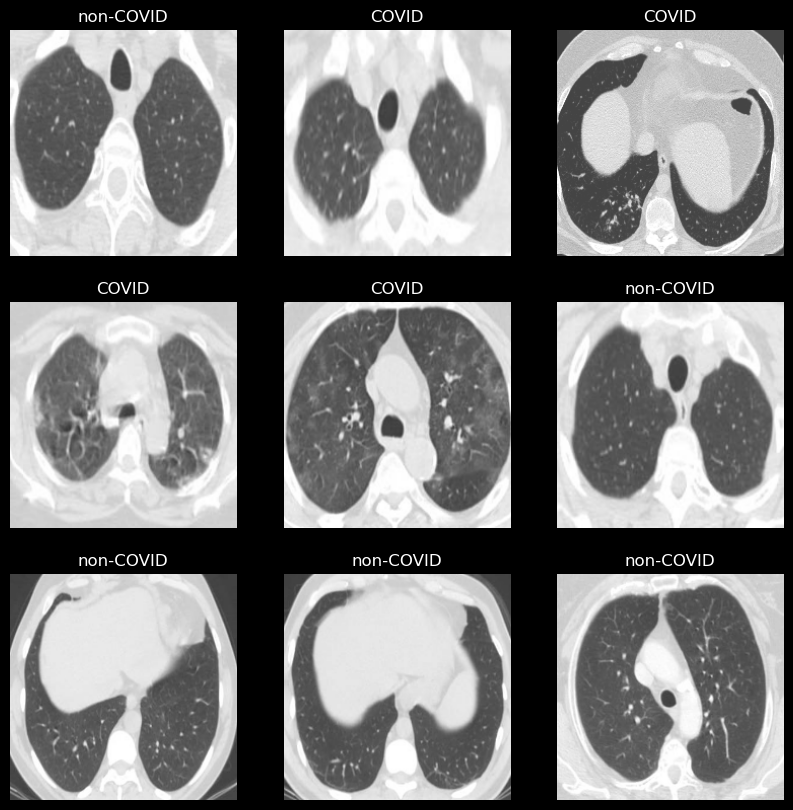

In [9]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

The autotune caches the training and validation datasets in memory and prefetches the next batch of data with a buffer size.
This helps to improve performance by reducing the amount of time that the model has to wait for data.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.22209165 1.0


## Create the model

The model contains four convolutional layers, each followed by a max pooling layer. The model uses a series of convolutional layers to extract features from the images, and then uses a dense layer to classify the images. The last layer is a dense layer with one neuron, which outputs a probability between 0 and 1 indicating whether the CT scan is COVID or non-COVID.

In [12]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2), 
   layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'), 
    
    layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        1

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model

The model is trained for 10 epochs the early stopping callback that will stop training if the validation loss does not improve for 3 epochs. The early stopping callback helps to prevent the model from overfitting to the training data.

In [14]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  callbacks=[callback],shuffle = True,
  epochs = 10
)

Epoch 1/10
16/16 [==============================] - 23s 1s/step - loss: 0.9308 - accuracy: 0.5330 - val_loss: 0.6685 - val_accuracy: 0.6875
Epoch 2/10
16/16 [==============================] - 18s 1s/step - loss: 0.6142 - accuracy: 0.6650 - val_loss: 0.5637 - val_accuracy: 0.6996
Epoch 3/10
16/16 [==============================] - 18s 1s/step - loss: 0.5250 - accuracy: 0.7320 - val_loss: 0.4779 - val_accuracy: 0.7762
Epoch 4/10
16/16 [==============================] - 16s 1s/step - loss: 0.4045 - accuracy: 0.8282 - val_loss: 0.4209 - val_accuracy: 0.8125
Epoch 5/10
16/16 [==============================] - 18s 1s/step - loss: 0.3305 - accuracy: 0.8645 - val_loss: 0.3747 - val_accuracy: 0.8266
Epoch 6/10
16/16 [==============================] - 17s 1s/step - loss: 0.3096 - accuracy: 0.8675 - val_loss: 0.4153 - val_accuracy: 0.8044
Epoch 7/10
16/16 [==============================] - 16s 1s/step - loss: 0.2444 - accuracy: 0.8972 - val_loss: 0.2778 - val_accuracy: 0.8810
Epoch 8/10
16/16 [==

In [15]:
import numpy as np

# Assuming you have trained your model and defined 'val_ds' previously

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Predict labels
y_pred_probs = model.predict(val_ds)
y_pred = (y_pred_probs > 0.5).astype(np.int32)  # Assuming binary classification

# Now 'y_true' contains the true labels, and 'y_pred' contains the predicted labels
y_pred = y_pred.flatten()
y_true = y_true.flatten()

4/4 [==============================] - 2s 301ms/step


## Visualize training results

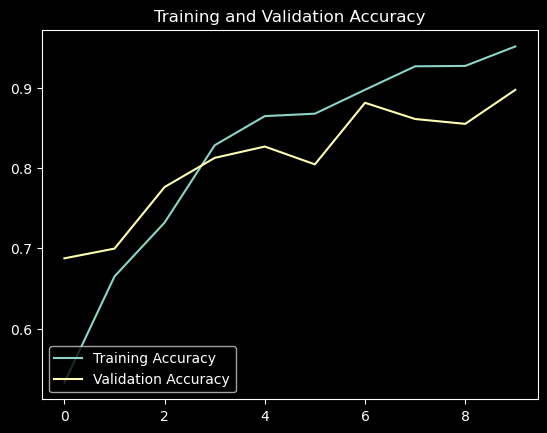

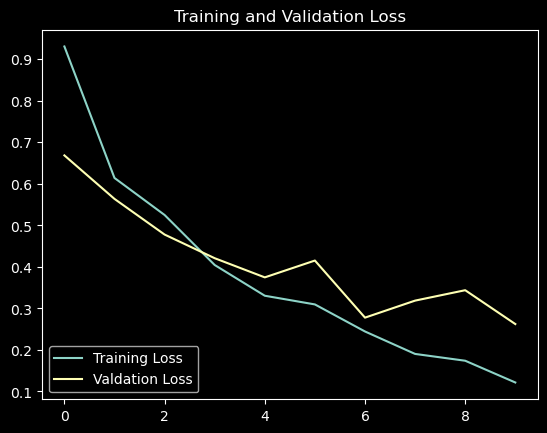

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Valdation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## Predictions

1/1 [==============================] - 0s 335ms/step
This image is most likely COVID .


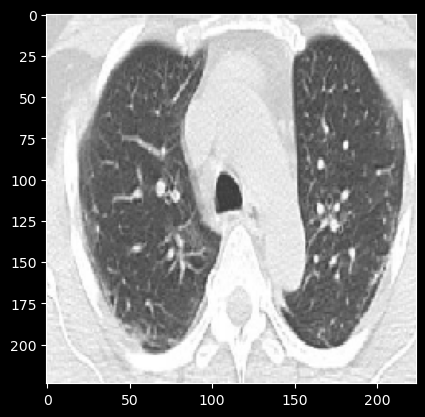

In [18]:
img_path = r"C:\Users\saira\Downloads\New_Data_CoV2-annotation\New_Data_CoV2\Covid\Patient (59)\CT-Scan paitent 59 (4).png"
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]
print("This image is most likely {} .".format(class_names[round(score[0])]))
plt.imshow(img)


1/1 [==============================] - 0s 47ms/step
This image is most likely non-COVID .


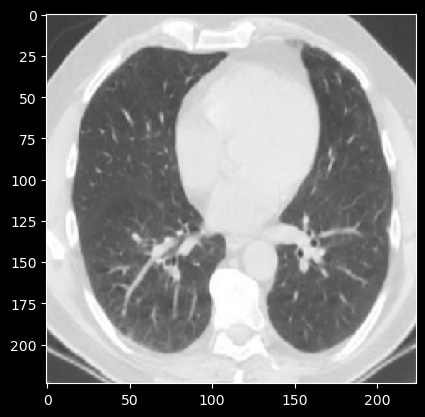

In [19]:
img_path =r"C:\Users\saira\Downloads\corona datset\non-COVID\Non-Covid (85).png"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is most likely {} ."
    .format(class_names[round(score[0])])
)

plt.imshow(img)

1/1 [==============================] - 0s 63ms/step
This image is most likely COVID


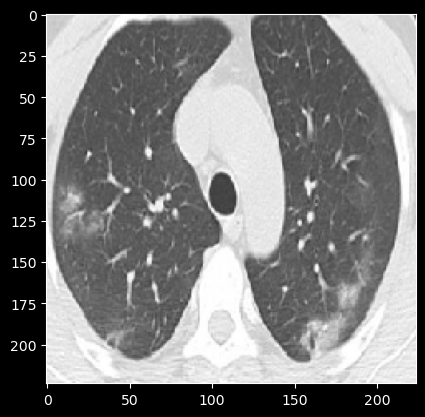

In [20]:
from tensorflow.keras.preprocessing import image
import os
directory = r"C:\Users\saira\Downloads\New_Data_CoV2-annotation\New_Data_CoV2\Covid\Patient (25)"
target_size=(img_height, img_width)
loaded_images=[]

for filename in  os.listdir(directory):
    if filename.endswith ('.jpg') or filename.endswith('.png'):
        img_path=os.path.join(directory,filename)
        img=image.load_img(img_path,target_size=target_size)
        loaded_images.append(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is most likely {}"
    .format(class_names[round(score[0])])
)

plt.imshow(img)

In [23]:
import pandas as pd

In [24]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

# Print the results DataFrame
print("Actual vs. Predicted DataFrame:")
print(results_df)

Actual vs. Predicted DataFrame:
     Actual  Predicted
0         0          0
1         1          1
2         0          0
3         1          0
4         1          1
..      ...        ...
491       0          0
492       0          0
493       0          0
494       1          1
495       0          0

[496 rows x 2 columns]


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# actual values

actual = y_true

# predicted values

predicted = y_pred

# confusion matrix

matrix = confusion_matrix(actual,predicted, labels=[1,0],sample_weight=None, normalize=None)
print('Confusion matrix : \n', matrix)

# outcome values order in sklearn

tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy

C_Report = classification_report(actual,predicted,labels=[1,0])

print('Classification report : \n', C_Report)

# calculating the metrics

sensitivity = round(tp/(tp+fn), 3);
specificity = round(tn/(tn+fp), 3);
accuracy = round((tp+tn)/(tp+fp+tn+fn), 3);
balanced_accuracy = round((sensitivity+specificity)/2, 3);
precision = round(tp/(tp+fp), 3);
f1Score = round((2*tp/(2*tp + fp + fn)), 3);

# Matthews Correlation Coefficient (MCC). Range of values of MCC lie between -1 to +1. 
# A model with a score of +1 is a perfect model and -1 is a poor model

from math import sqrt

mx = (tp+fp) * (tp+fn) * (tn+fp) * (tn+fn)
MCC = round(((tp * tn) - (fp * fn)) / sqrt(mx), 3)

print('Accuracy :', round(accuracy*100, 2),'%')
print('Precision :', round(precision*100, 2),'%')
print('Recall :', round(sensitivity*100,2), '%')
print('F1 Score :', f1Score)
print('Specificity or True Negative Rate :', round(specificity*100,2), '%'  )
print('Balanced Accuracy :', round(balanced_accuracy*100, 2),'%')
print('MCC :', MCC)

Confusion matrix : 
 [[225  17]
 [ 34 220]]
Outcome values : 
 225 17 34 220
Classification report : 
               precision    recall  f1-score   support

           1       0.87      0.93      0.90       242
           0       0.93      0.87      0.90       254

    accuracy                           0.90       496
   macro avg       0.90      0.90      0.90       496
weighted avg       0.90      0.90      0.90       496

Accuracy : 89.7 %
Precision : 86.9 %
Recall : 93.0 %
F1 Score : 0.898
Specificity or True Negative Rate : 86.6 %
Balanced Accuracy : 89.8 %
MCC : 0.796


In [26]:
import pandas as pd
# Get classification report as a dictionary
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(report_dict).transpose()

# Print the results DataFrame
print("Results DataFrame:")
print(results_df)

Results DataFrame:
              precision    recall  f1-score     support
0              0.928270  0.866142  0.896130  254.000000
1              0.868726  0.929752  0.898204  242.000000
accuracy       0.897177  0.897177  0.897177    0.897177
macro avg      0.898498  0.897947  0.897167  496.000000
weighted avg   0.899218  0.897177  0.897142  496.000000


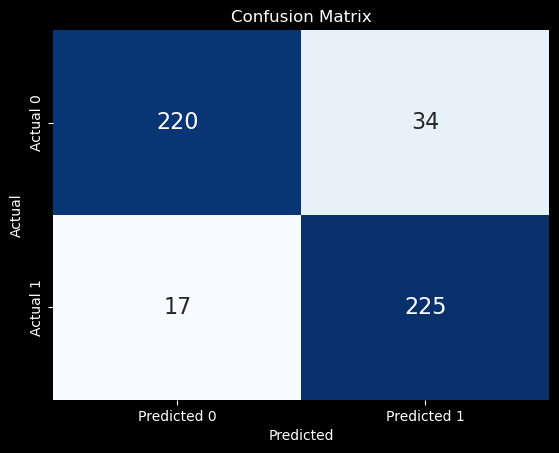

In [27]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

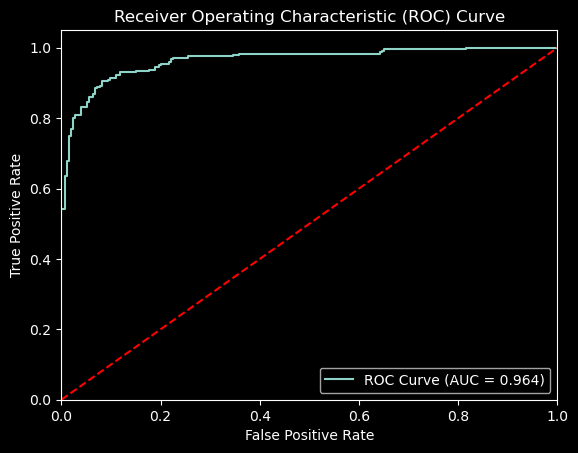

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve.png')
plt.show()

# How to Interpret a ROC Curve
The more that the ROC curve hugs the top left corner of the plot, the better the model does at classifying the data into categories.

To quantify this, we can calculate the AUC (area under the curve) which tells us how much of the plot is located under the curve.

The closer AUC is to 1, the better the model.

A model with an AUC equal to 0.5 would be a perfectly diagonal line and it would represent a model that is no better than a model that makes random classifications.